# Chapter 8: Conditional GAN

Conditional GAN is a GAN variant presented in the paper [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) by *Mehdi Mirza* and *Simon Osindero*. This architecture allows to direct the generator what samples to create.

The provided example in this notebook is using the MNIST dataset to train a generator and allows to tell the generator what number should be generated. The CGAN has the following architecture.
![Architecture](img/architecture.png)

# Imports

Some PyTorch modules and classes are imported as well as `tqdm` to provide graphical feedback during training and `matplotlib` for plotting graphs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
import torch.cuda as cuda
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Lambda

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Loading data

We use the PyTorch data loading capabilities and define the function `get_z_vector` to get a latent vector $z$ of the desired length.

The PyTorch `torchvision` package provides a convenient way to access the MNIST dataset. The images in the dataset come in the range $\left[0, 255\right]$ and are first converted to a tensor in the range $\left[0.0, 1.0\right]$ and finally normalized with `Lambda` to be in $\left[-1.0, +1.0\right]$.

In [2]:
# A transform which results that the images are in the desired range
trans = Compose([ToTensor(), Lambda(lambda x: x * 2 - 1)])

# The actual MNIST dataset on which the transformation is applied
train_set = MNIST('~/pytorch', train=True, transform=trans, download=True)

# Function to get the latent vector z
def get_z_vector(batch_size, length):
    return torch.randn(batch_size, length)

# Support CUDA

In PyTorch GPU (CUDA) support is done explicitly by moving the tensors to the device. Therefore, we define the variable `device` which is used in the following code to execute the tensors on the GPU or CPU.

In [3]:
if cuda.is_available():
    print("Using cuda device for training")
    device = 'cuda'
else:
    print("Using cpu for training")
    device = 'cpu'

Using cuda device for training


# Generator

The generator takes as input a latent vector $z$ and a label $y$ and converts it to an image.

![Generator](img/generator.png)

The input vector $z$ and a embedding of the label $embed(y)$ are elementwise multiplied before passed to `Linear` layer. This layer is than reshaped to a three dimensional feature map of shape $(256, 7, 7)$ before passed to transposed convolutional layers `ConvTranspose2d`.

In [4]:
class Generator(nn.Module):
    def __init__(self, num_classes, z_dim):
        super().__init__()
        
        # Embedding which outputs a vector of dimension z_dim
        self.embed = nn.Embedding(num_classes, z_dim)
        
        # Linear combination of the latent vector z
        self.dense = nn.Linear(z_dim, 7 * 7 * 256)
        
        # The transposed convolutional layers are wrapped in nn.Sequential
        self.trans1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        
        self.trans2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        
        self.trans3 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh())
        
    def forward(self, z, label):
        # Apply embedding to the input label
        embedded_label = self.embed(label)
        
        # Element wise multiplication of latent vector and embedding
        x = embedded_label * z
        
        # Application of dense layer and transforming to 3d shape
        x = self.dense(x).view(-1, 256, 7, 7)
        x = self.trans1(x)
        x = self.trans2(x)
        x = self.trans3(x)
        
        return x

# Discriminator

The descriminator converts the inputs $(x, y)$ into a prediction $\sigma$, which is the probablity that the input is sampled from a real distribution $p_{data}$. The architecture is shown in the image below.

![Discriminator](img/discriminator.png)

The discriminator embeds the label $embed(y)$ and concatinates it with the image $x$. After that, three `Conv2d` layers with `LeakyReLU` activation and `BatchNorm2d` follow. Note that the fist layer does not use batch normalization.

At the end of the network a `Linear` layer is used with `Sigmoid` activation.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super().__init__()

        # Embedding which outputs a vector of img_size
        self.embed = nn.Embedding(num_classes, img_size[0] * img_size[1])
        
        # It convenient to group conv layers with nn.Sequential
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=2, padding=1),
            nn.LeakyReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        
        # The 3D feature map is flattened to perform a linear combination
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 128, 1),
            nn.Sigmoid())
        
    def forward(self, x, label):
        # Apply embedding and convert to same shape as x
        embedded_label = self.embed(label).view_as(x)
        
        # Concatenation of x and embedded label
        x = torch.cat([x, embedded_label], dim=1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dense(x)
        
        return x

# Training

In [6]:
NUM_CLASSES = 10
Z_DIM = 100
IMG_SIZE = (28, 28)

Generator and discriminater are instantiated as well as an `Adam` optimizer for each model. The optimizing criteria for each model is a Binary Cross Entropy Loss `BCELoss`.

In [7]:
# Generator is instantiated
generator = Generator(NUM_CLASSES, Z_DIM).to(device)

# Discriminator is instantiated
discriminator = Discriminator(NUM_CLASSES, IMG_SIZE).to(device)

# Discriminator and generator have their own optimizer
g_optim = optim.Adam(generator.parameters(), lr=0.001)
d_optim = optim.Adam(discriminator.parameters(), lr=0.001)

# Binary cross entropy loss is used for discriminator and generator
criterion = nn.BCELoss()

The train function instantiates a `RandomSampler` and `DataLoader` to iterate through the dataset randomly in batch sizes. The training of the generator and discriminator are performed as follows:

1. The discriminator is trained to predict correctly for real images
2. The discriminator is trained to predict correctly for fake images
3. The generator is trained to force the discrimintor to predict incorrectly on fake images

In [8]:
def train(batch_size, iterations, sample_interval):
    # A random sampler which will provide the indicies to the DataLoader
    sampler = RandomSampler(train_set, replacement=True, num_samples=batch_size * iterations)

    # The DataLoader which provides us batches of data samples
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, drop_last=True)
    
    # Vectors for real (all one) and fake (all zero) labels
    y_real = torch.ones(batch_size, 1).to(device)
    y_fake = torch.zeros(batch_size, 1).to(device)

    # The losses are recorded all sample_interval
    losses = []

    # Variables used for recording of losses
    iteration = 0
    d_loss = 0.0
    g_loss = 0.0
    
    for x, labels in tqdm(train_loader):
        # Tensors have to be moved to the desired device
        x = x.to(device)
        labels = labels.to(device)

        #
        # 1. Train discriminator on real images
        #
        
        # Perform forward pass for real images and calculate loss
        d_out = discriminator(x, labels)
        d_loss_real = criterion(d_out, y_real)

        # Optimize according to the calculated loss
        d_optim.zero_grad()
        d_loss_real.backward()
        d_optim.step()

        
        #
        # 2. Train discriminator on fake images
        #
        
        # Generate fake images and perform forward pass for fake images and
        # calculate loss
        x_gen = generator(get_z_vector(batch_size, Z_DIM).to(device), labels)
        d_out = discriminator(x_gen, labels)
        d_loss_fake = criterion(d_out, y_fake)
        
        # Optimize according to the calculated loss
        d_optim.zero_grad()
        d_loss_fake.backward()
        d_optim.step()
        
        #
        # 3. Train generator to force discriminator making false predictions
        #
        
        # Generate fake images and perform forward pass for fake images but
        # real labels and calculate loss
        x_gen = generator(get_z_vector(batch_size, Z_DIM).to(device), labels)
        d_out = discriminator(x_gen, labels)
        g_loss_real = criterion(d_out, y_real)
        
        # Optimize according to the calculated loss
        g_optim.zero_grad()
        g_loss_real.backward()
        g_optim.step()

        # Calculate discriminator and generator loss for visualization
        d_loss += 0.5 * (d_loss_real + d_loss_fake).item()
        g_loss += g_loss_real.item()

        iteration += 1
        
        if iteration % sample_interval == 0:
            # Calculate the loss for the last sample_interval iterations
            d_loss = d_loss / sample_interval
            g_loss = g_loss / sample_interval
            
            print(f"D-Loss: {d_loss:.4f} G-Loss: {g_loss:.4f}")
            
            # Add loss and reset for next iterations
            losses.append((d_loss, g_loss))
            d_loss = 0
            g_loss = 0

    return losses

Training is performed with a batch `batch_size=32`, `iterations=12000` and `sample_interval=1000`

In [9]:
losses = train(batch_size=32, iterations=12000, sample_interval=1000)

D-Loss: 0.1308 G-Loss: 4.8754
D-Loss: 0.2342 G-Loss: 3.4194
D-Loss: 0.2532 G-Loss: 2.9811
D-Loss: 0.2838 G-Loss: 2.8567
D-Loss: 0.3105 G-Loss: 2.6349
D-Loss: 0.3068 G-Loss: 2.5829
D-Loss: 0.3039 G-Loss: 2.5526
D-Loss: 0.3246 G-Loss: 2.5178
D-Loss: 0.3188 G-Loss: 2.4922
D-Loss: 0.3082 G-Loss: 2.6052
D-Loss: 0.3023 G-Loss: 2.5696
D-Loss: 0.3157 G-Loss: 2.5355



# Visualizations

## Generator
The visualization of the generator shows that the generator is capable to create convincing digits with variation that can be controlled with the label `y`. The functions is adapted from the book GANs in Action.

In [10]:
def sample_digits(generator, image_grid_rows=6, image_grid_columns=10):
    # Sample random noise
    z = get_z_vector(image_grid_rows * image_grid_columns, 100).to(device)

    # Generate images from random noise
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z, torch.tensor([i for _ in range(image_grid_rows) for i in range(0, 10)], device=device)).cpu().detach().view(-1, 28, 28).numpy()
        generator.train()

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 6),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

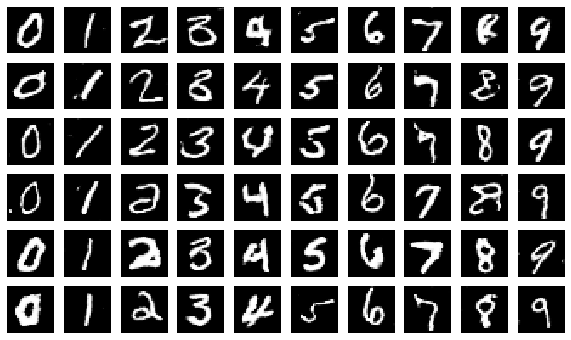

In [11]:
sample_digits(generator)

## Generator and discriminator loss
Visualization of the discriminator and generator loss while iterating through the batches

In [12]:
def plot_losses(data):
    checkpoints = range(0, len(data) * 1000, 1000)
    plt.figure(figsize=(15,5))
    plt.plot(checkpoints, [x[0] for x in data], label='Discriminator')
    plt.plot(checkpoints, [x[1] for x in data], label='Generator')
    plt.ylabel("Loss")
    plt.xlabel("Batches")
    plt.legend()
    plt.show()

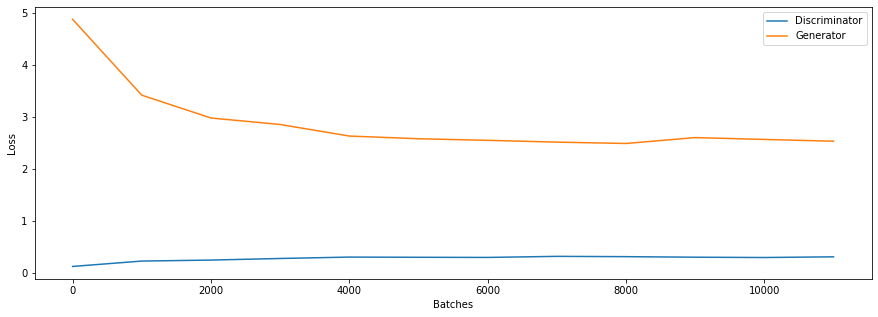

In [13]:
plot_losses(losses)